## Init notebook

This is run once.

## Preliminaries

In [14]:
import quantus

In [16]:


# Import libraries.
from IPython.display import clear_output
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import warnings
import torch
import captum
import torchvision
import wandb
from tqdm import tqdm
import os

from zennit import attribution as zattr
from zennit import image as zimage
from zennit import composites as zcomp

from models import models
from data import dataloaders, datasets, transforms
from attribution import zennit_utils as zutils
from utils import arguments as argument_utils
from main import *

try:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print('Using device:', torch.cuda.get_device_name(0))
except:
    pass

/home/lweber/work-code/Quantus/quantus/__init__.py
Using device: NVIDIA TITAN RTX


/home/lweber/work-code/Quantus/eMPRT/scripts/main.py:411: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if xai_methodname is not "grad-cam":


## Plots



417it [04:29,  1.55it/s]                         

Setting up filters...
417
[10]



/tmp/ipykernel_56124/3916389917.py:67: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, ax = plt.subplots(1, 1, figsize=(10, 6))
/tmp/ipykernel_56124/3916389917.py:84: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = cm.get_cmap("tab10")(np.linspace(0, 1, 10))


IndexError: list index out of range

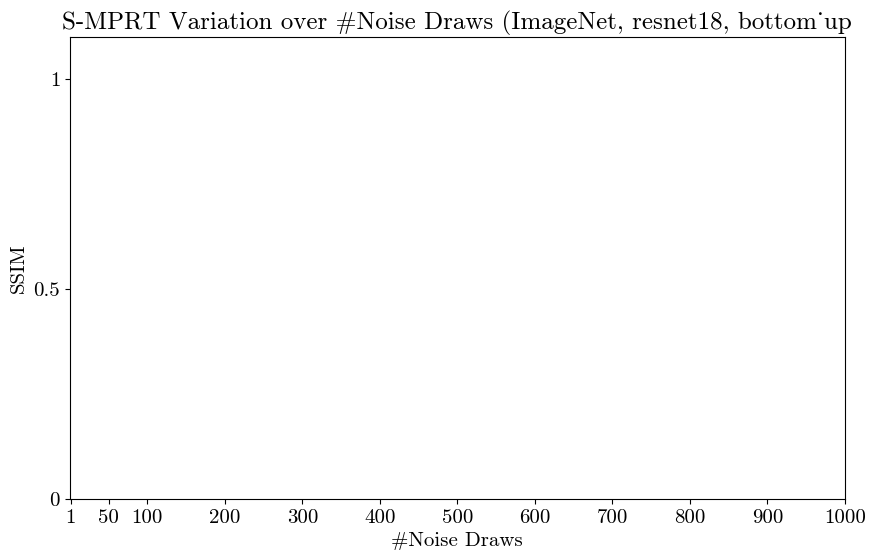

In [24]:
os.environ["WANDB_API_KEY"] = "343d642ebb6021c0303b16436ddf0be59cb0696f"
wandb_projectname = "denoise-sanity-checks"
between_plot_filter = ["eval_layer_order", "model_name"]
within_plot_filter = ["xai_methodname"]
x_axis_attribute = "xai_n_noisedraws"
legend_str = {"top_down": "top-down", "bottom_up": "bottom_up"}
method_str = {"gradient": "Gradient", "lrp-epsilon": r"LRP-$\varepsilon$", "lrp-zplus": r"LRP-$z^+$", "guided-backprop": "Guided Backprop", "grad-cam": "GradCAM"}

#download_filter = {"seed": 8666, "model_name": "vgg16", "eval_layer_order": "top_down"}
download_filter = {}

# Get all results from wandb
print("Downloading Results from wandb...")
res = []
api = wandb.Api()
entity, project = "leanderweber", wandb_projectname  # set to your entity and project 
runs = api.runs(entity + "/" + project) 
with tqdm(total=len(runs)) as pbar:
    for run in runs: 
        # .summary contains the output keys/values for metrics like accuracy.
        #  We call ._json_dict to omit large files 
        config = {k: v for k,v in run.config.items() if not k.startswith('_')}
        if all([config[s] == v for s, v in download_filter.items()]):
            history = run.scan_history()
            metric_list = []
            for row in history:
                metric_list.append(row["mean-score"])

            res.append((config, metric_list))

        pbar.update(1)

print("Setting up filters...")
between_plot_filters = []
within_plot_filters = []
for config, _ in res:
    duplicate = False
    for fil in between_plot_filters:
        if all([config[filtered_category] == fil[filtered_category] for filtered_category in between_plot_filter]):
            duplicate=True
    if not duplicate:
        between_plot_filters.append({filtered_category: config[filtered_category] for filtered_category in between_plot_filter})

    duplicate = False
    for fil in within_plot_filters:
        if all([config[filtered_category] == fil[filtered_category] for filtered_category in within_plot_filter]):
            duplicate=True
    if not duplicate:
        within_plot_filters.append({filtered_category: config[filtered_category] for filtered_category in within_plot_filter})

print(len(res))

for bpf in between_plot_filters:

    bpf_runs = [(c, m) for c, m in res if all([c[filtered_category] == bpf[filtered_category] for filtered_category in between_plot_filter])]

    # Init Plot
    import matplotlib as mpl
    import matplotlib.font_manager as font_manager
    mpl.rcParams['font.family']='serif'
    cmfont = font_manager.FontProperties(fname=mpl.get_data_path() + '/fonts/ttf/cmr10.ttf')
    mpl.rcParams['font.serif']=cmfont.get_name()
    mpl.rcParams['mathtext.fontset']='cm'
    mpl.rcParams['axes.unicode_minus']=False
    import matplotlib.pyplot as plt
    plt.rcParams.update({'font.size': 8})
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))

    ax.set_title(f"S-MPRT Variation over #Noise Draws (ImageNet, {bpf['model_name']}, {legend_str[bpf['eval_layer_order']]}")

    ax.set_ylabel("SSIM")
    ax.set_ylim([0.0, 1.1])
    ax.set_yticks([0, 0.5, 1.0])
    ax.set_yticklabels([0, 0.5, 1])

    ax.set_xlabel("#Noise Draws")
    ax.set_xlim([0, 1000])
    ax.set_xticks([1, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000])
    ax.set_xticklabels([1, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000])

    alphas = [1.0, 0.75, 0.5]
    std_alpha = 0.2
    hlinealpha = 0.5
    palette = cm.get_cmap("tab10")(np.linspace(0, 1, 10))
    markers = [".","d", "D"]
    linewidth = 2.5


    for w, wpf in enumerate(within_plot_filters):
        
        wpf_runs = [(c, m) for c, m in bpf_runs if all([c[filtered_category] == wpf[filtered_category] for filtered_category in within_plot_filter])]

        # Sort Runs

        layer_ids = [0, int(len(bpf_runs[0][1])/2),len(bpf_runs[0][1])-1]
        for l, layer_id in enumerate(layer_ids):

            x_axis_attribute_vals = sorted(list(set([c[x_axis_attribute] for c, m  in wpf_runs])))
            print(x_axis_attribute_vals)
            runs_to_plot = {p: [] for p in x_axis_attribute_vals}
            for c, m in wpf_runs:
                x_attr = c[x_axis_attribute]
                runs_to_plot[x_attr].append(m[layer_id])

            means = np.array([np.mean(m) for p, m in runs_to_plot.items()])
            stds = np.array([np.std(m) for p, m in runs_to_plot.items()])
            delta = means[-1] - means[0]

            ax.plot(x_axis_attribute_vals, means, alpha=alphas[l], linewidth=linewidth, marker=markers[l], color=palette[w], label=r"{} Layer {}, $\Delta=${:.2f}".format(method_str[wpf["xai_methodname"]], layer_id, delta))
            #plt.axhline(y=means[0], color=palette[w], linestyle='-', linewidth=1, zorder=0, alpha=hlinealpha)
            ax.fill_between(x_axis_attribute_vals, means+stds, means-stds, facecolor=palette[w], alpha=std_alpha)

    plt.legend()
    plt.tight_layout()

    savefile = os.path.join("/media/lweber/f3ed2aae-a7bf-4a55-b50d-ea8fb534f1f5/mptc/figures/smprt-raw", "{}-{}-{}.svg".format("imagenet", bpf['model_name'], legend_str[bpf['eval_layer_order']]))
    fig.savefig(savefile)
    plt.show()

# xticklocs = [0] + [5*1875, 10*1875, 15*1875, 20*1875]
# xticklabels = ["0", "5", "10", "15", "20"]

# ax.set_xticks(xticklocs)
# ax.set_xticklabels(xticklabels)
# ax.set_xlabel("Epoch")

# ax.legend()

# fig.subplots_adjust(left=0.2, right=0.95, bottom=0.2, top=0.95, wspace=0, hspace=0)

# savefile = os.path.join(root, "{}-{}.svg".format(metric_to_plot, constraintstr))
# fig.savefig(savefile)
